# **Erstelle Varianten für die Simulation**

# Importe

In [1]:
### Jupyter Einstellungen
%load_ext autoreload
%autoreload 2

In [2]:
### Python Packages
import re
import os
import datetime as dt
import pandas as pd
import scipy.stats as st
from scipy.stats import norm, lognorm, uniform, qmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [5]:
from src import style
from src import toolbox as tb
from sklearn.metrics import r2_score
from src import trnpy

In [6]:
style.clrs

[(0.2870588235294118, 0.48156862745098034, 0.5756862745098039),
 (0.7109803921568627, 0.36588235294117644, 0.28117647058823525),
 (0.2886274509803921, 0.4329411764705882, 0.4329411764705883),
 (0.891764705882353, 0.687843137254902, 0.30823529411764694),
 (0.6572549019607843, 0.5192156862745099, 0.6196078431372549),
 (0.10901960784313725, 0.1749019607843137, 0.2282352941176471)]

# **Erstellen der Simulation**

## **Erstelle Bauteile, Fenster und Wandaufbauten**
___

### Öffne die hinterlegte Fensterdatenbank

In [7]:
w = trnpy.LizardWindowDB()
w.df.head()

,id,U,SHGC,TVIS,NAME
id,,,,,
100,100,5.72,0.84,0.0,NoGlas
101,101,5.72,0.84,0.0,Float5mm
102,102,5.69,0.82,0.0,Float6mm
103,103,5.62,0.80,0.0,Float8mm
104,104,5.56,0.77,0.0,Float10mm


### Lade die Standard-Datenbanken (Materialien und Wandaufbauten) mit der Klasse `KONSTRUKTION()`

In [8]:
k = trnpy.KONSTRUKTION()

SICHTBETONDECKE: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
Achtung! Resistance Layer haben per Definition keine Dichte
HOLZFASER: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
LEICHTBETON_NEU: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
NORMALBETON: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
HOLZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
LEICHTBAUPLATTE: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
BS_HOLZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
MINERALWOLLE: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
GELOCHTER_ZIEGEL: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
AUSSENPUTZ_KALK: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
HOCHLOCHZIEGEL: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
ZEMENTESTRICH: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
FIBO_SPERRHOLZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
OSB: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
MAUERWERK: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
KALKZEMENTPUTZ: ['GWP', 'PERT', 'PENRT'] nicht hinterlegt
LINOLEUM: ['GWP', 'PERT', 'PENRT'] nicht hinterleg

2. Speichere die Datenbank wieder ab.

In [9]:
k.export()
k.Walls

Materialdatenbank wurde als ./sim/trnpy\MATERIALS.csv exportiert!
Konstruktionsdatenbank wurde als ./sim/trnpy\WALLS.csv exportiert!


{'BO': WALL_OBJECT <BO>: d=0.30m, U=3.450 W/(m²*K), Mass=720.0 kg/m²,
 'DA': WALL_OBJECT <DA>: d=0.45m, U=0.161 W/(m²*K), Mass=12.5 kg/m²,
 'FBH_DUMMY': WALL_OBJECT <FBH_DUMMY>: d=0.46m, U=0.791 W/(m²*K), Mass=720.0 kg/m²,
 'GEG_AW': WALL_OBJECT <GEG_AW>: d=0.36m, U=0.202 W/(m²*K), Mass=7.5 kg/m²,
 'GEG_BO': WALL_OBJECT <GEG_BO>: d=0.35m, U=0.687 W/(m²*K), Mass=600.0 kg/m²,
 'GEG_DA': WALL_OBJECT <GEG_DA>: d=0.47m, U=0.205 W/(m²*K), Mass=120.0 kg/m²,
 'GEG_IW_H': WALL_OBJECT <GEG_IW_H>: d=0.21m, U=2.624 W/(m²*K), Mass=27.0 kg/m²,
 'GEG_IW_L': WALL_OBJECT <GEG_IW_L>: d=0.16m, U=0.257 W/(m²*K), Mass=9.0 kg/m²,
 'LB_AW': WALL_OBJECT <LB_AW>: d=0.50m, U=0.357 W/(m²*K), Mass=160.0 kg/m²,
 'LB_IW_H': WALL_OBJECT <LB_IW_H>: d=0.24m, U=3.450 W/(m²*K), Mass=576.0 kg/m²,
 'LB_IW_L': WALL_OBJECT <LB_IW_L>: d=0.24m, U=3.450 W/(m²*K), Mass=576.0 kg/m²,
 'MH_AW': WALL_OBJECT <MH_AW>: d=0.30m, U=0.224 W/(m²*K), Mass=150.0 kg/m²,
 'MH_IW_H': WALL_OBJECT <MH_IW_H>: d=0.23m, U=0.318 W/(m²*K), Mass=32.8 

### Erstelle einen ``Bauweise()``-Container mit einer Bauweise für die Simulation. Ein Container spezifiziert die Bauteilaufbauten für die in der Simulation verwendeten Wandaufbauten.

In [10]:
buid = []

for bui in ['LB','MH', 'MW']:
    b = trnpy.Bauweise(
        Name = bui, 
        AW = k.Walls[f'{bui}_AW'], 
        IW_H = k.Walls[f'{bui}_IW_H'], 
        IW_L = k.Walls[f'{bui}_IW_L'], 
        DA = k.Walls[f'DA'],
        BO = k.Walls[f'BO'],
        FBH = None,
        ActiveLayer = 0,
        WindowID = 3307,
        THB = {'LB':0.018, 'MH': 0.024, 'MW': 0.023}[bui],
        )
    buid.append(b)

for f in ['GEG']:
    buid.append(trnpy.Bauweise(
        Name = f, AW=k.Walls[f'{f}_AW'], 
        IW_H=k.Walls[f'{f}_IW_H'], 
        IW_L=k.Walls[f'{f}_IW_L'], 
        DA=k.Walls[f'{f}_DA'], 
        BO=k.Walls[f'{f}_BO'], 
        WindowID = 3307, 
        ActiveLayer = 0))

buid

[BAUWEISE <LB>, BAUWEISE <MH>, BAUWEISE <MW>, BAUWEISE <GEG>]

In [11]:
(pd.concat({item.Name: item.info for item in buid})
.rename_axis(['Variante', 'idx'])
.rename(index=style.NAMES, columns={'Name': 'Bezeichnung'})
.style
.format({'Dicke': '{:2n}', 'U-Wert': '{:.3n}', 'Masse': '{:1n}', 'THB': '{:.3n}'}, escape='latex')
.hide(axis="index", level=1)
# .to_latex(
#     './LaTex/tbls/tbl_model_bauweisen.tex',
#     caption=r'Thermisch dynamische Kenngrößen der simulierten Bauweisen. Dicke in [\si{\metre}], U-Werte in [\si{\watt\per\square\metre\per\kelvin}], Masse in [\si{\kilo\gram\per\square\meter}], Wärmebrückenzuschlag (THB) in [\si{\watt\per\square\metre\per\kelvin}] ',
#     clines="skip-last;data",
#     siunitx=True,
#     hrules=True,
#     position= 'H',
#     position_float="centering",
#     multicol_align="|c|",
#     label='tbl:Model:Bauweisen')
)

## **Wetter**
___

### `.epw`-Dateien

In [12]:
def makeAMBfromEPW(fn):
    a = trnpy.epw()
    a.read(fn)
    df = pd.DataFrame()
    df['Datetime'] = pd.to_datetime(a.df[['Year', 'Month', 'Day', 'Hour']])
    #df.index = df.index.set_names(['Datetime'])
    df['T_amb'] = a.df['Dry Bulb Temperature']
    df['Rh_amb'] = a.df['Relative Humidity']
    df['windspeed'] = a.df['Wind Speed']
    df['global'] = a.df['Global Horizontal Radiation']
    df['direct'] = a.df['Direct Normal Radiation']
    df['diffuse'] = a.df['Diffuse Horizontal Radiation']
    return df.set_index('Datetime')

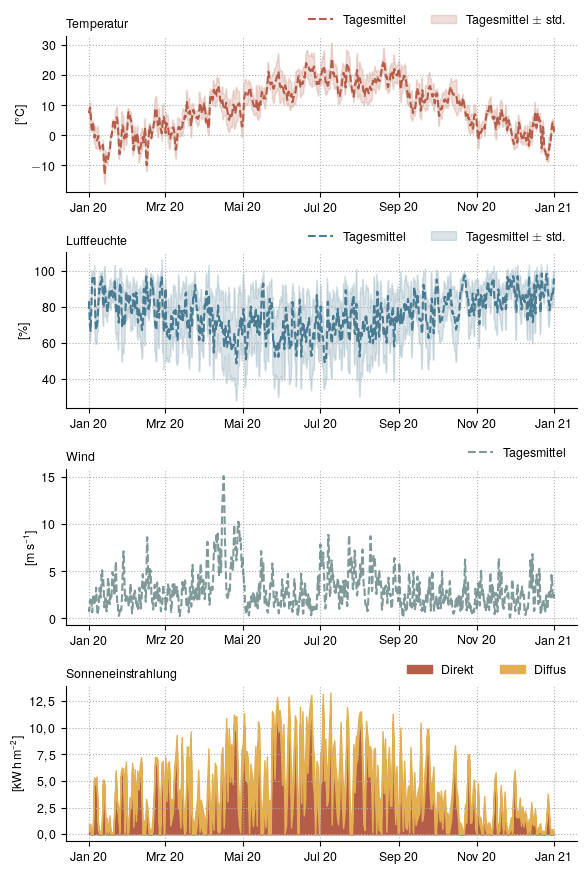

In [13]:
amb = makeAMBfromEPW('sim/trnpy/weatherfiles/MUC_2020.epw')

fig, axs = plt.subplots(4,1,**style.size(1.5))
i=0
#----#1: Temperaturen ----
axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\celsius}]')
axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed', label=r'Tagesmittel', c = style.red)
upper = amb.T_amb.rolling('D').mean() + amb.T_amb.rolling('D').std()
lower = amb.T_amb.rolling('D').mean() - amb.T_amb.rolling('D').std()
x = upper.index
axs[i].fill_between(x, lower, upper, label=r'Tagesmittel $\pm$ std.', color = style.red, alpha=0.2)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#2: Luftfeuchte ----
axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\percent}]')
axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed', label='Tagesmittel', c = style.blue)
upper = amb.Rh_amb.rolling('D').mean() + amb.Rh_amb.rolling('D').std()
lower = amb.Rh_amb.rolling('D').mean() - amb.Rh_amb.rolling('D').std()
x = upper.index
axs[i].fill_between(x, lower, upper, label=r'Tagesmittel $\pm$ std.', color = style.blue, alpha=0.2)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#3: Wind ----

axs[i].set_title('Wind', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\metre\per\second}]')
axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Tagesmittel', linestyle='dashed', c = style.green, alpha=0.7)

axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
i+=1

#----#4: Globalstrahlung ----

axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
axs[i].set_ylabel(r'[\si{\kilo\watt\hour\per\square\metre}]')
df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
axs[i].fill_between(df_p.index, 0, df_p['direct'], color=style.red, label = 'Direkt', alpha=1)
axs[i].fill_between(df_p.index, df_p['direct'], df_p['diffuse']+df_p['direct'],  color=style.yellow, label = 'Diffus', alpha=1)
#axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=style.red, label = 'Direkt', alpha=1)
#axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=style.yellow, label = 'Diffus', alpha=1)
axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

for ax in axs:
    ax.grid(which='both')
    
fig.tight_layout()

### `.109`-Dateien

In [14]:
w = trnpy.weather109()
w.read_file(path='./src/db/template_weatherfile.109')
df1 = trnpy.PeriodToDatetimeIndex(w.df, 2005)
w.name = 'Beispiel_109_File'
print(w.name)
#w.df['TAMB'].update()
#w.export()
w.df

Beispiel_109_File


,IBEAM_H,IDIFF_H,TAMB,WSPEED,RHUM,WDIR,CCOVER,PAMB
1,0.0,0.0,0.1,2.8,89.0,30.0,8.0,969.1
2,0.0,0.0,0.1,2.1,89.0,10.0,8.0,970.4
3,0.0,0.0,0.1,1.5,89.0,10.0,8.0,971.2
4,0.0,0.0,0.1,1.4,86.0,70.0,8.0,970.9
5,0.0,0.0,0.1,1.0,86.0,50.0,8.0,970.5
...,...,...,...,...,...,...,...,...
8756,0.0,0.0,3.7,3.8,86.0,60.0,8.0,963.2
8757,0.0,0.0,2.5,4.7,80.0,90.0,8.0,963.8
8758,0.0,0.0,1.4,5.5,78.0,110.0,8.0,964.4
8759,0.0,0.0,0.6,5.0,80.0,100.0,8.0,965.8


## **Schedules**
___
Erstelle Schedules zum import in TRNLIZARD

### Tagesschedules

1. Erstelle eine (Tages-)Schedule Datenbank 

In [15]:
DailySchedules = trnpy.ScheduleCollection(mode='DAY')
DailySchedules

DAYSCHEDULE-COLLECTION: <0 Schedules>

2. Erstelle zwei Schedules und füge sie der Datenbank hinzu.

In [16]:
wd = trnpy.Schedule(Name='NATVENT_WD')
wd.setDomain(8.5,8.75,1)
wd.setDomain(18.25,18.5,1)
DailySchedules.add(wd)

we = trnpy.Schedule(Name='NATVENT_WE')
we.setDomain(8.5,8.75,1)
we.setDomain(18.25,18.5,1)
DailySchedules.add(we)
DailySchedules

DAYSCHEDULE-COLLECTION: <2 Schedules>

3. Übersicht über die angelegten Schedules

In [17]:
DailySchedules()

,0,1,2,3,4,5
NATVENT_WD,0.00 0.00,7.50 1.00,7.75 0.00,17.25 1.00,17.50 0.00,24.00 0.00
NATVENT_WE,0.00 0.00,7.50 1.00,7.75 0.00,17.25 1.00,17.50 0.00,24.00 0.00


4. Exportiere die Schedule-Collection ins Projektverzeichnis

In [18]:
DailySchedules.export('sim/trnpy')

Erfolgreich unter sim/trnpy\SCHED_DAY_COLLECTION.csv gespeichert!


### Wochenschedule

1. Initialisiere Schedule-Collection

In [19]:
WeeklySchedules = trnpy.ScheduleCollection()
WeeklySchedules

WEEKSCHEDULE-COLLECTION: <0 Schedules>

2. Weise jedem Wochentag einen Daily-Schedule zu.

In [20]:
weekarray = [wd,wd,wd,wd,wd,we,we]
ws = trnpy.Weekschedule(Name='NATVENT')
ws.setWeek(weekarray)
ws.Daysarray
WeeklySchedules.add(ws)

# ws = trnpy.Weekschedule(Name='Test2')
# ws.setWeek(weekarray)
# ws.Daysarray
# WeeklySchedules.add(ws)

WeeklySchedules()

,0,1,2,3,4,5,6
NATVENT,NATVENT_WD,NATVENT_WD,NATVENT_WD,NATVENT_WD,NATVENT_WD,NATVENT_WE,NATVENT_WE


3. Speichere die Collection ab.

In [21]:
WeeklySchedules.export(dest='sim/trnpy/')

Erfolgreich unter sim/trnpy/SCHED_WEEK_COLLECTION.csv gespeichert!


## **Erstelle die Varianten für die Simulation**
___

## Eine Klasse die mir die eine Variante erstellt. Die einzelnen Varianten werden dann in einem Pandas DataFrame gespeichert. 

1) Definiere die unsicheren Randbedinungen für die a Priori Monte-Carlo-Simulation

Anzahl unsicherer Randbedingungen: 3, Anzahl Ausprägungen: 10


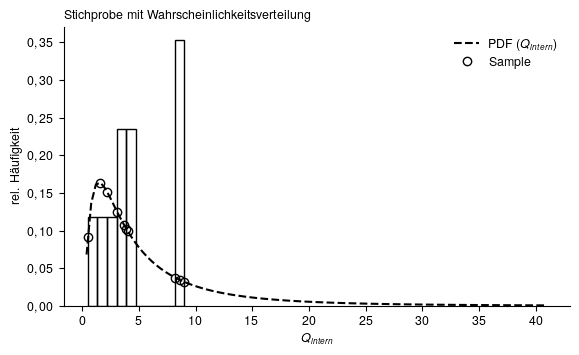

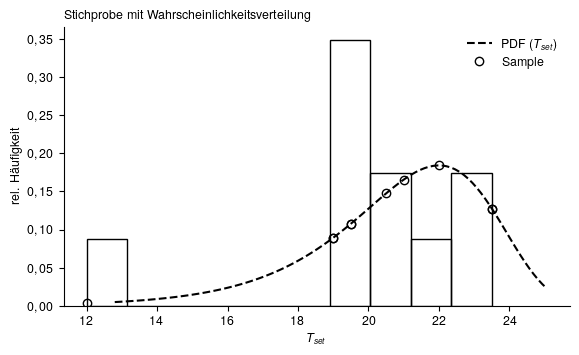

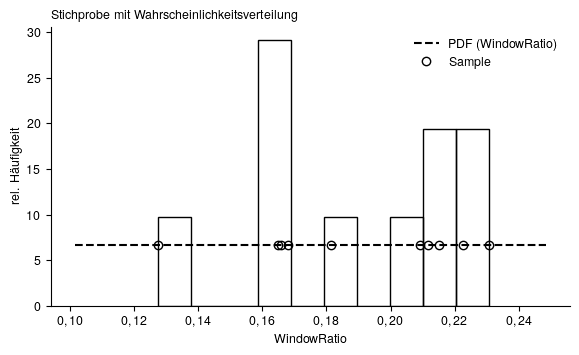

In [22]:
from scipy.stats import norm, lognorm, uniform, gumbel_l

m = 10
MonteCarloVariablen = {
    'IntGain': trnpy.MC_variable(r'$Q_{intern}$', lognorm(s=1, scale=4), size=m, accuracy=1),
    'Tset': trnpy.MC_variable(r'$T_{set}$', gumbel_l(loc=22, scale=2), accuracy=0.5, size=m),
    'WindowRatio': trnpy.MC_variable('WindowRatio', uniform(loc=0.1, scale=0.15), accuracy=5, size=m)
    }

MonteCarloVariablen['IntGain'].plot()
MonteCarloVariablen['Tset'].plot()
MonteCarloVariablen['WindowRatio'].plot()

N_RB = len(MonteCarloVariablen)
N_RB_i = min(np.array([item.n for item in MonteCarloVariablen.values()]))
print(f'Anzahl unsicherer Randbedingungen: {N_RB}, Anzahl Ausprägungen: {N_RB_i}')

2) Definiere die sicheren Randbedinungungen. 
    
    `Hinweis: Jede sichere Randbedinung wird mit JEDER unsicheren Randbedinung kombiniert`

In [23]:
Varianten = {
    'bui': buid,
    'WeatherFile': ['MUC_2020.epw', 'MUC_2050.epw']
        }

n_Varianten = [len(item) for item in Varianten.values()]
print(f'Anzahl Varianten: {len(Varianten)} mit {n_Varianten} Ausprägungen, bei {N_RB_i} Ausprägungen der Randbedinungen ergibt das {np.product([len(item) for item in Varianten.values()]) * N_RB_i} Simulationen')

Anzahl Varianten: 2 mit [4, 2] Ausprägungen, bei 10 Ausprägungen der Randbedinungen ergibt das 80 Simulationen


4) Erstelle eine Variable für eine *In Simulation* Monte Carlo simulation

In [24]:
# test = trnpy.MC_variable(r'$T_{set}$', 'gumbel', Mu=22.47, Sigma=1.13, Sample=[np.random.rand() for i in range(0,8761)],SampleRound=1)
# test.plot()

# df = pd.concat([pd.Series(test.sample, name='Tset_Sample')],axis=1).round(2)
# df.to_csv('./sim/trnpy/HourlyVariable_Test.csv', index=False, sep=' ')

Exportiere die erstellten Varianten nach TRNLizard

In [25]:
Simulationen = trnpy.VariantCollection()
Simulationen.MonteCarloVariants(
    SimName='TRNPY_TEMPLATE', 
    Varianten = Varianten, 
    unsichereRB = MonteCarloVariablen
    )
Simulationen.export()
Simulationen()

,bui,WeatherFile,IntGain,Tset,WindowRatio,IntWall_L,IntWall_H,ExtWall,Floor,Ceiling,Laibung,WindowID,ActiveLayer,THB
Name,,,,,,,,,,,,,,
TRNPY_TEMPLATE_0,LB,MUC_2020.epw,9.0,19.5,0.16505,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_1,LB,MUC_2020.epw,3.9,19.0,0.23076,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_2,LB,MUC_2020.epw,3.7,12.0,0.18130,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_3,LB,MUC_2020.epw,3.1,19.5,0.12759,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_4,LB,MUC_2020.epw,8.2,19.0,0.22267,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRNPY_TEMPLATE_75,GEG,MUC_2050.epw,8.6,21.0,0.21175,GEG_IW_L,GEG_IW_H,GEG_AW,GEG_BO,GEG_DA,0.36,3307,0,0.050
TRNPY_TEMPLATE_76,GEG,MUC_2050.epw,4.0,23.5,0.16817,GEG_IW_L,GEG_IW_H,GEG_AW,GEG_BO,GEG_DA,0.36,3307,0,0.050
TRNPY_TEMPLATE_77,GEG,MUC_2050.epw,0.5,23.5,0.20906,GEG_IW_L,GEG_IW_H,GEG_AW,GEG_BO,GEG_DA,0.36,3307,0,0.050


Öffne gespeicherte Varianten

In [26]:
Simulationen = trnpy.VariantCollection()
Simulationen.open()
Simulationen()

,bui,WeatherFile,IntGain,Tset,WindowRatio,IntWall_L,IntWall_H,ExtWall,Floor,Ceiling,Laibung,WindowID,ActiveLayer,THB
Name,,,,,,,,,,,,,,
TRNPY_TEMPLATE_0,LB,MUC_2020.epw,9.0,19.5,0.165,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_1,LB,MUC_2020.epw,3.9,19.0,0.231,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_2,LB,MUC_2020.epw,3.7,12.0,0.181,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_3,LB,MUC_2020.epw,3.1,19.5,0.128,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
TRNPY_TEMPLATE_4,LB,MUC_2020.epw,8.2,19.0,0.223,LB_IW_L,LB_IW_H,LB_AW,BO,DA,0.50,3307,0,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRNPY_TEMPLATE_75,GEG,MUC_2050.epw,8.6,21.0,0.212,GEG_IW_L,GEG_IW_H,GEG_AW,GEG_BO,GEG_DA,0.36,3307,0,0.050
TRNPY_TEMPLATE_76,GEG,MUC_2050.epw,4.0,23.5,0.168,GEG_IW_L,GEG_IW_H,GEG_AW,GEG_BO,GEG_DA,0.36,3307,0,0.050
TRNPY_TEMPLATE_77,GEG,MUC_2050.epw,0.5,23.5,0.209,GEG_IW_L,GEG_IW_H,GEG_AW,GEG_BO,GEG_DA,0.36,3307,0,0.050
